In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [33]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Returns'] = yen_futures.Settle.pct_change() * 100
yen_futures.dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Returns
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,-93.110968,99153.0,145470.0,2135.392010,-104.360369
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,140.950891,159397.0,144474.0,-93.110968,-251.379472
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,-97.054754,158810.0,147471.0,140.950891,-168.857141
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,-626.321511,69457.0,153902.0,-97.054754,545.328011
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,-340.466988,108342.0,151564.0,-626.321511,-45.640221


### Lagged Returns 

In [35]:
# Create a lagged return using the shift function
yen_futures['Lagged_Returns'] = yen_futures.Returns.pct_change() * 100
yen_futures['Lagged_Returns'] = yen_futures.Returns.shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Returns,Lagged_Returns
Date,,,,,,,,,,,
2014-03-25,9787.0,9799.0,9760.0,9783.0,2.0,-1.163070e+02,98773.0,159644.0,-7.456275e+02,-8.440146e+01,8.108516e+02
2014-03-26,9783.0,9816.0,9750.0,9803.0,19.0,-1.000188e+02,103659.0,157853.0,-1.163070e+02,-1.400451e+01,-8.440146e+01
2014-03-27,9803.0,9836.0,9766.0,9791.0,11.0,-5.138175e+06,139488.0,158635.0,-1.000188e+02,5.137109e+06,-1.400451e+01
2014-03-28,9787.0,9805.0,9714.0,9731.0,60.0,-8.497587e+01,133863.0,157742.0,-5.138175e+06,-9.999835e+01,5.137109e+06
2014-03-31,9725.0,9732.0,9671.0,9714.0,39.0,-3.827103e+02,133280.0,170203.0,-8.497587e+01,3.503752e+02,-9.999835e+01


### Train Test Split

In [36]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [44]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Returns'].to_frame()
X_test = test['Lagged_Returns'].to_frame()
y_train = train['Returns']
y_test = test['Returns']

In [45]:
X_train

,Lagged_Returns
Date,
2014-03-25,8.108516e+02
2014-03-26,-8.440146e+01
2014-03-27,-1.400451e+01
2014-03-28,5.137109e+06
2014-03-31,-9.999835e+01
...,...
2018-12-24,5.537379e+02
2018-12-26,-8.611359e+01
2018-12-27,-4.079613e+02


# Linear Regression Model

In [46]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [47]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [48]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results['Predicted Results'] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF328798C8>,
      dtype=object)

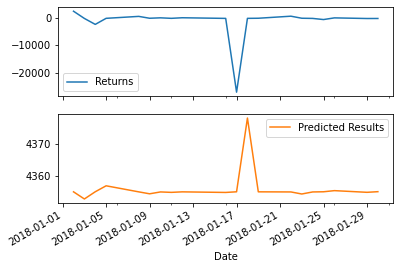

In [49]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!

Out-of-Sample Root Mean Squared Error (RMSE): 0.41521675083603804


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [14]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

In-sample Root Mean Squared Error (RMSE): 0.5658708047560468


# Conclusions

YOUR CONCLUSIONS HERE!